In [171]:
import datetime as dt
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from copy import copy

pd.set_option('display.max_rows', 500)

<h1> Get all GTSF data </h1>

In [152]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null
    and (b.is_qa = false or b.captured_at > '2019-09-19');
"""
df = rds_access_utils.extract_from_database(query)

In [153]:
blacklisted_keypoint_annotation_ids = [
    606484, 
    635806, 
    637801, 
    508773, 
    640493, 
    639409, 
    648536, 
    507003,
    706002,
    507000,
    709298,
    714073,
    719239
]

df = df[~df.id.isin(blacklisted_keypoint_annotation_ids)]

<h1> Filter dataset down to well-behaved rows </h1>

In [154]:
def contains_complete_kp_info(row):
    if 'leftCrop' in row.keypoints and 'rightCrop' in row.keypoints:
        return True
    return False


In [155]:
complete_kp_info_mask = df.apply(lambda x: contains_complete_kp_info(x), axis=1)
df = df[complete_kp_info_mask]

<h1> Append world keypoints to this data </h1>

In [159]:
def get_world_keypoints(row):
    if 'leftCrop' in row.keypoints and 'rightCrop' in row.keypoints:
        return pixel2world(row.keypoints['leftCrop'], row.keypoints['rightCrop'], row.camera_metadata)
    else:
        return None
    
def is_well_behaved(wkps, cutoff_depth=10.0):
    if any([abs(wkp[1]) > cutoff_depth for wkp in wkps.values()]):
        return False
    return True

df['world_keypoints'] = df.apply(
    lambda x: get_world_keypoints(x), axis=1
)

is_well_behaved_mask = df.world_keypoints.apply(lambda x: is_well_behaved(x))
df = df[is_well_behaved_mask]

<h1> Create Datasets + Transforms </h1>

In [79]:
import json, os

BODY_PARTS = sorted([
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'DORSAL_FIN',
    'EYE',
    'HYPURAL_PLATE',
    'LOWER_PRECAUDAL_PIT',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'TAIL_NOTCH',
    'UPPER_LIP',
    'UPPER_PRECAUDAL_PIT'
])


class KeypointsDataset(Dataset):
    """Keypoints dataset"""

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        if self.transform:
            sample = self.transform(row)
            return sample

        world_keypoints = row.world_keypoints
        weight = row.weight

        sample = {'kp_input': world_keypoints, 'label': weight, 'keypoint_annotation_id': row.id}

        return sample


In [80]:
class NormalizeCentered2D(object):
    
    """
    Transforms the 2D left and right keypoints such that:
        (1) The center of the left image 2D keypoints is located at the center of the left image
            (i.e. 2D translation)
        (2) The left image keypoints are possibly flipped such that the upper-lip x-coordinate 
            is greater than the tail-notch coordinate. This is done to reduce the total number of 
            spatial orientations the network must learn from -> reduces the training size
        (3) The left image keypoints are then rotated such that upper-lip is located on the x-axis.
            As in (2), this is done to reduce the total number of spatial orientations the network 
            must learn from -> reduces the training size
        (4) For all transformations above, the right image keypoint coordinates are accordingly
            transformed such that the original disparity values are preserved for all keypoints
    """


    def flip_center_kps(self, left_kps, right_kps):

        x_min_l = min([kp[0] for kp in left_kps.values()])
        x_max_l = max([kp[0] for kp in left_kps.values()])
        x_mid_l = np.mean([x_min_l, x_max_l])

        y_min_l = min([kp[1] for kp in left_kps.values()])
        y_max_l = max([kp[1] for kp in left_kps.values()])
        y_mid_l = np.mean([y_min_l, y_max_l])

        x_min_r = min([kp[0] for kp in right_kps.values()])
        x_max_r = max([kp[0] for kp in right_kps.values()])
        x_mid_r = np.mean([x_min_r, x_max_r])

        y_min_r = min([kp[1] for kp in right_kps.values()])
        y_max_r = max([kp[1] for kp in right_kps.values()])
        y_mid_r = np.mean([y_min_r, y_max_r])

        fc_left_kps, fc_right_kps = {}, {}
        flip_factor = 1 if left_kps['UPPER_LIP'][0] > left_kps['TAIL_NOTCH'][0] else -1
        for bp in BODY_PARTS:
            left_kp, right_kp = left_kps[bp], right_kps[bp]
            if flip_factor > 0:
                fc_left_kp = np.array([left_kp[0] - x_mid_l, left_kp[1] - y_mid_l])
                fc_right_kp = np.array([right_kp[0] - x_mid_l, right_kp[1] - y_mid_l])
            else:
                fc_right_kp = np.array([x_mid_r - left_kp[0], left_kp[1] - y_mid_r])
                fc_left_kp = np.array([x_mid_r - right_kp[0], right_kp[1] - y_mid_r])
            fc_left_kps[bp] = fc_left_kp
            fc_right_kps[bp] = fc_right_kp

        return fc_left_kps, fc_right_kps


    def _rotate_cc(self, p, theta):
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        rotated_kp = np.dot(R, p)
        return rotated_kp


    def rotate_kps(self, left_kps, right_kps):
        upper_lip_x, upper_lip_y = left_kps['UPPER_LIP']
        theta = np.arctan(upper_lip_y / upper_lip_x)
        r_left_kps, r_right_kps = {}, {}
        for bp in BODY_PARTS:
            rotated_kp = self._rotate_cc(left_kps[bp], -theta)
            r_left_kps[bp] = rotated_kp
            disp = abs(left_kps[bp][0] - right_kps[bp][0])
            r_right_kps[bp] = np.array([rotated_kp[0] - disp, rotated_kp[1]])

        return r_left_kps, r_right_kps


    def translate_kps(self, left_kps, right_kps, factor):
        t_left_kps, t_right_kps = {}, {}
        for bp in BODY_PARTS:
            left_kp, right_kp = left_kps[bp], right_kps[bp]
            t_left_kps[bp] = factor * np.array(left_kps[bp])
            t_right_kps[bp] = factor * np.array(right_kps[bp])

        return t_left_kps, t_right_kps


    def jitter_kps(self, left_kps, right_kps, jitter):
        j_left_kps, j_right_kps = {}, {}
        for bp in BODY_PARTS:
            j_left_kps[bp] = np.array([left_kps[bp][0] + np.random.normal(0, jitter), 
                                       left_kps[bp][1] + np.random.normal(0, jitter)])
            j_right_kps[bp] = np.array([right_kps[bp][0] + np.random.normal(0, jitter), 
                                        right_kps[bp][1] + np.random.normal(0, jitter)])

        return j_left_kps, j_right_kps



    def modify_kps(self, left_kps, right_kps, factor, jitter, cm):
        fc_left_kps, fc_right_kps = self.flip_center_kps(left_kps, right_kps)
        r_left_kps, r_right_kps = self.rotate_kps(fc_left_kps, fc_right_kps)
        t_left_kps, t_right_kps = self.translate_kps(r_left_kps, r_right_kps, factor)
        j_left_kps, j_right_kps  = self.jitter_kps(t_left_kps, t_right_kps, jitter)
        j_left_kps_list, j_right_kps_list = [], []
        for bp in BODY_PARTS:
            l_item = {
                'keypointType': bp,
                'xFrame': j_left_kps[bp][0] + cm['pixelCountWidth'] / 2.0,
                'yFrame': j_left_kps[bp][1] + cm['pixelCountHeight'] / 2.0
            }

            r_item = {
                'keypointType': bp,
                'xFrame': j_right_kps[bp][0] + cm['pixelCountWidth'] / 2.0,
                'yFrame': j_right_kps[bp][1] + cm['pixelCountHeight'] / 2.0
            }

            j_left_kps_list.append(l_item)
            j_right_kps_list.append(r_item)

        modified_kps = {
            'leftCrop': j_left_kps_list,
            'rightCrop': j_right_kps_list
        }

        return modified_kps
    
    def __init__(self, lo=None, hi=None, jitter=0.0):
        self.lo = lo
        self.hi = hi
        self.jitter = jitter
    
    def __call__(self, row):
        left_keypoints_list = row.keypoints['leftCrop']
        right_keypoints_list = row.keypoints['rightCrop']
        left_kps = {item['keypointType']: np.array([item['xFrame'], item['yFrame']]) for item in left_keypoints_list}
        right_kps = {item['keypointType']: np.array([item['xFrame'], item['yFrame']]) for item in right_keypoints_list}
        cm = row.camera_metadata
        
        factor = 1.0 
        if self.lo and self.hi:
            factor = np.random.uniform(low=self.lo, high=self.hi)
            
        jitter = np.random.uniform(high=self.jitter)
        
        modified_kps = self.modify_kps(left_kps, right_kps, factor, jitter, cm)
        modified_wkps = pixel2world(modified_kps['leftCrop'], modified_kps['rightCrop'], cm)
        
        sample = {
            'kp_input': modified_wkps,
            'label': row.weight,
            'keypoint_annotation_id': row.id,
            'cm': row.camera_metadata
        }
        
        return sample
        


class NormalizedStabilityTransform(object):
    
    def __call__(self, sample):
        kp_input, label, kpid = sample['kp_input'], sample['label'], sample['keypoint_annotation_id']
        stabilized_coordinates = {}
        for bp in BODY_PARTS:
            wkp = kp_input[bp]
            stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]
            stabilized_coordinates[bp] = stabilized_kp_info
            
        normalized_label = label * 1e-4
        
        transformed_sample = {
            'kp_input': stabilized_coordinates,
            'label': normalized_label,
            'keypoint_annotation_id': kpid
        }
        
        return transformed_sample
        

In [ ]:
class ToTensor(object):
    
    def __call__(self, sample):
        kp_input, label, keypoint_annotation_id = \
            sample['kp_input'], sample['label'], sample['keypoint_annotation_id']
        
        x = []
        for bp in BODY_PARTS:
            kp_data = kp_input[bp]
            x.append(kp_data)
        x = np.array(x)
        
        kp_input_tensor = torch.from_numpy(x).float()
        label_tensor = torch.from_numpy(np.array([label])).float()
        
        tensorized_sample = {
            'kp_input': kp_input_tensor,
            'label': label_tensor,
            'keypoint_annotation_id': keypoint_annotation_id
        }
        
        return tensorized_sample
        
        
        
        

In [177]:
gtsf_fish_identifiers = list(df.fish_id.unique())
train_size = int(0.8 * len(gtsf_fish_identifiers))
fish_ids = random.sample(gtsf_fish_identifiers, train_size)
date_mask = (df.captured_at < '2019-09-10')
train_mask = date_mask & df.fish_id.isin(fish_ids)
test_mask = date_mask & ~df.fish_id.isin(fish_ids)


In [178]:
train_dataset = KeypointsDataset(df[train_mask], transform=transforms.Compose([
                                                      NormalizeCentered2D(lo=0.3, hi=2.0, jitter=10),
                                                      NormalizedStabilityTransform(),
                                                      ToTensor()
                                                  ]))

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=1)

In [196]:
test_dataset = KeypointsDataset(df[test_mask], transform=transforms.Compose([
                                                      NormalizeCentered2D(lo=0.3, hi=2.0, jitter=10),
                                                      NormalizedStabilityTransform(),
                                                      ToTensor()
                                                  ]))

test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True, num_workers=1)

In [197]:
# TODO: Define your network architecture here
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(33, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x
        



In [ ]:
# establish output directory where model .pb files will be written
dt_now = dt.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
output_base = '/root/data/alok/biomass_estimation/results/neural_network'
output_dir = os.path.join(output_base, dt_now)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# instantiate neural network
# network = Network()
epochs = 500
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

# track train and test losses
# train_losses, test_losses = [], []

for epoch in range(200, epochs):
    running_loss = 0.0
    for i, data_batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        X_batch, y_batch, kpid_batch = \
            data_batch['kp_input'], data_batch['label'], data_batch['keypoint_annotation_id']
        y_pred = network(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
            
    # run on test set
    else:
        test_running_loss = 0.0
        with torch.no_grad():
            for i, data_batch in enumerate(test_dataloader):
                X_batch, y_batch, kpid_batch = \
                    data_batch['kp_input'], data_batch['label'], data_batch['keypoint_annotation_id']
                y_pred = network(X_batch)
                loss = criterion(y_pred, y_batch)
                test_running_loss += loss.item()

    train_loss_for_epoch = running_loss / len(train_dataloader)
    test_loss_for_epoch = test_running_loss / len(test_dataloader)
    train_losses.append(train_loss_for_epoch)
    test_losses.append(test_loss_for_epoch)
    
    # save current state of network
    f_name = 'nn_epoch_{}.pb'.format(str(epoch).zfill(3))
    f_path = os.path.join(output_dir, f_name)
    torch.save(network, f_path)
    
    # print current loss values
    print('-'*20)
    print('Epoch: {}'.format(epoch))
    print('Train Loss: {}'.format(train_loss_for_epoch))
    print('Test Loss: {}'.format(test_loss_for_epoch))
    
    


--------------------
Epoch: 200
Train Loss: 0.0009142990264570482
Test Loss: 0.001373010106764415
--------------------
Epoch: 201
Train Loss: 0.0009224302096035492
Test Loss: 0.0014257620678436397
--------------------
Epoch: 202
Train Loss: 0.0009221539333801749
Test Loss: 0.001233749232949219
--------------------
Epoch: 203
Train Loss: 0.0009241597064871516
Test Loss: 0.0014006599636018477
--------------------
Epoch: 204
Train Loss: 0.0009149918726987621
Test Loss: 0.001494255375488334
--------------------
Epoch: 205
Train Loss: 0.000942146989895207
Test Loss: 0.0014510436200113079
--------------------
Epoch: 206
Train Loss: 0.0008917493340273371
Test Loss: 0.001387103794505484
--------------------
Epoch: 207
Train Loss: 0.0009020889993393013
Test Loss: 0.001439124895343641
--------------------
Epoch: 208
Train Loss: 0.0009094024936613657
Test Loss: 0.0014323763746499746
--------------------
Epoch: 209
Train Loss: 0.0008969524995613114
Test Loss: 0.0012980704801471752
----------------

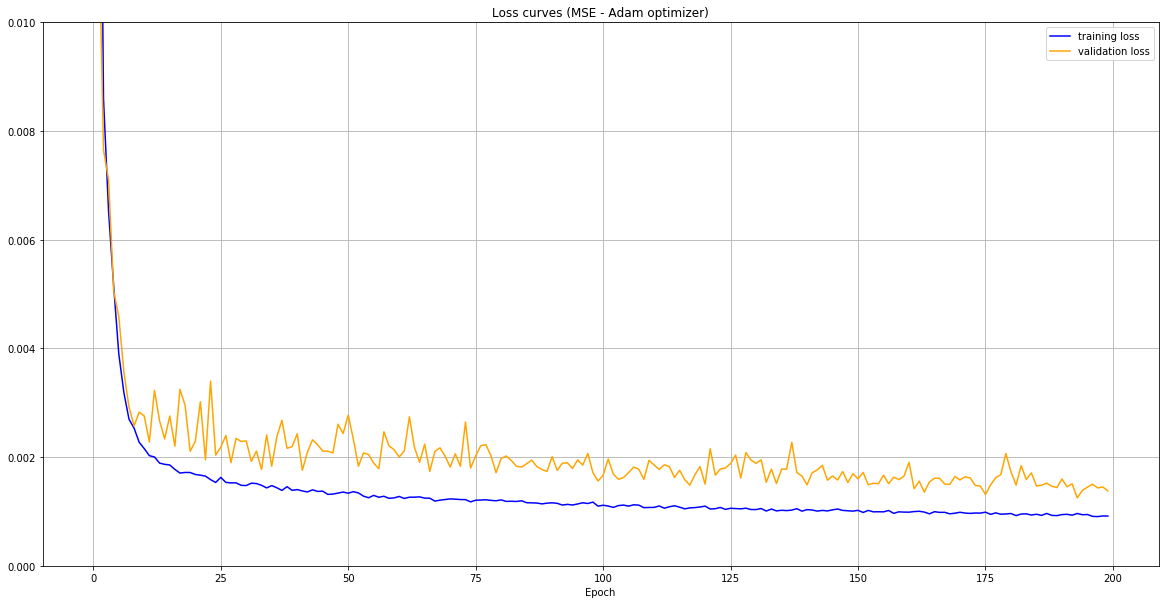

In [202]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(train_losses)), train_losses, color='blue', label='training loss')
plt.plot(range(len(test_losses)), test_losses, color='orange', label='validation loss')
plt.ylim([0, 0.01])
plt.xlabel('Epoch')
plt.title('Loss curves (MSE - Adam optimizer)')
plt.legend()
plt.grid()
plt.show()